In [1]:
import pandas as pd
import numpy as np

In [2]:
train = pd.read_csv('data/WSJ_02-21.pos', sep='\t', header=0, names=['word', 'pos'])
test = pd.read_csv('data/WSJ_24.pos', sep='\t', header=0, names=['word', 'pos'])

In [3]:
train.head()

,word,pos
0,an,DT
1,Oct.,NNP
2,19,CD
3,review,NN
4,of,IN


In [4]:
vocab = list(set(train.itertuples(index=False, name=None)))
index_to_pair = {k:v for k, v in enumerate(vocab)}
pair_to_index = {v:k for k, v in index_to_pair.items()}

In [5]:
sequence_length = 20
input_data = []
for tup in train.itertuples(index=False, name=None):
    input_data.append(tup)
input_data[:10]

[('an', 'DT'),
 ('Oct.', 'NNP'),
 ('19', 'CD'),
 ('review', 'NN'),
 ('of', 'IN'),
 ('``', '``'),
 ('The', 'DT'),
 ('Misanthrope', 'NN'),
 ("''", "''"),
 ('at', 'IN')]

In [6]:
index_to_pair[23]

('toured', 'VBD')

In [7]:
len(pair_to_index)

51659

In [8]:
pair_to_index[('cripple-maker', 'NN')]

39760

In [9]:
index_to_pair[0]

('plaintively', 'RB')

In [10]:
index_to_pos = {k:v for k, v in enumerate(list(set(train['pos'])))}
pos_to_index = {v:k for k, v in index_to_pos.items()}

In [11]:
index_to_word = {k:v for k, v in enumerate(list(set(train['word'])))}
word_to_index = {v:k for k, v in index_to_word.items()}

In [13]:
matrix = []
for index in range(len(input_data)):
    if index+sequence_length>len(input_data):
        break
    matrix.append(input_data[index:index+sequence_length])
    index+=sequence_length

In [14]:
transformed_matrix = []
for row in matrix:
    input_data = row[:-1]
    target = row[-1]
    transformed_matrix.append([pair_to_index[a] for a in input_data]+[word_to_index[target[0]]]+[pos_to_index[target[1]]])

In [15]:
transformed_input_data = np.array(transformed_matrix)

In [18]:
transformed_input_data[0]

array([48512, 12638, 30363, 48028, 24253,   586, 49429, 32326, 31781,
       34222, 15361, 25093, 20621, 43724,  8782,   586,  3361, 30825,
       14075,  9429,    42])

In [19]:
train_proportion = .8
cutoff_index = int(len(transformed_input_data) * train_proportion)
eval_sequences = transformed_input_data[cutoff_index:]
train_sequences = transformed_input_data[:cutoff_index]

In [20]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# 2 separate vocab sizes provided here. Targets are POS tags, input are tuples of word+tag
def GRULM(pair_vocab_size, pos_vocab_size, d_model=512, n_layers=2, mode='train'):
    model = keras.Sequential()

    model.add(layers.Embedding(input_dim=pair_vocab_size, output_dim=d_model))

    model.add(layers.LSTM(d_model))

    model.add(layers.Dense(pos_vocab_size))
    model.add(layers.Softmax())

    return model

In [45]:
X = train_sequences[:, :-1]
y = keras.utils.to_categorical(train_sequences[:, -1].reshape(-1,1))

X_val = eval_sequences[:, :-1]
y_val = keras.utils.to_categorical(eval_sequences[:, -1].reshape(-1,1))

In [48]:
len(y_val)

190002

In [64]:
model = GRULM(len(pair_to_index), len(pos_to_index))
model.compile(optimizer=tf.optimizers.Adam(), loss=tf.losses.CategoricalCrossentropy(), metrics=[tf.metrics.CategoricalAccuracy()])
# history = model.fit(X, y, validation_data=(X_val, y_val), batch_size=64, epochs=1)

<function matplotlib.pyplot.show(close=None, block=None)>

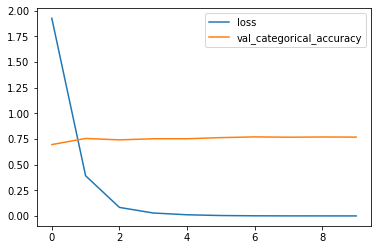

In [54]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_categorical_accuracy'], label='val_categorical_accuracy')
plt.legend()
plt.show

In [66]:
# model.predict(X[0])

In [65]:
#model.save('data/model')

In [60]:
results = []
for a in range(100):
    output = model.predict(X[a])
    results.append((index_to_pos[np.argmax(output[0])]== index_to_pos[transformed_matrix[a+1][-1]]))

In [61]:
np.mean(results)

0.08